In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import cpi
import seaborn as sns   
from cycler import cycler

In [2]:
cpu_performance_href = "https://jcmit.net/cpu-performance.htm"
memory_prices_href = "https://jcmit.net/memoryprice.htm"

In [3]:
cpu_performance_html = requests.get(cpu_performance_href)
memory_prices_html = requests.get(memory_prices_href)

if cpu_performance_html.ok and memory_prices_html.ok:
    print("Successfully fetched HTML content!")
    cpu_performance_html = cpu_performance_html.text
    memory_prices_html = memory_prices_html.text
else:
    print("Content fetching was unsuccessful. Please check internet connection.")

Successfully fetched HTML content!


In [4]:
def html_to_csv(content, memory=False):
    data = []
    list_header = []
    soup = BeautifulSoup(content, 'html.parser')
    header = soup.find_all("table")[0].find_all("tr")[0 if memory else 3]
    
    for items in header:
        col_name = items.get_text()
        if col_name == '\n':
            continue
        list_header.append(col_name)
        if col_name == 'Performance':
            list_header.append('Quantity')
        if col_name == 'JDR Chip Prices':
            list_header.extend(['', ''])
    idx = 2 if memory else 4
    HTML_data = soup.find_all("table")[0].find_all("tr")[idx:]
    
    for element in HTML_data:
        sub_data = []
        for sub_element in element:
            entry_name = sub_element.get_text()
            if entry_name == '\n':
                continue
            sub_data.append(entry_name)
        data.append(sub_data)
    return pd.DataFrame(data=data, columns=list_header)

In [5]:
# Fetch CPU performance data
cpu_performance_df = html_to_csv(cpu_performance_html)
cpu_performance_df.head()

,S/N,Year,Manufacturer,Model,Family,Category,size,Rental,Price US$,MB,...,LSI-11,S2000int,S2000fp,S00rateint,S00ratefp,Specmark89,Lias'80,Knight,ref:Knight,CS-859 rel
0,1,1944,Harvard U,Harvard Mark I,,,,,"442,686",,...,,,,,,,,0.0001,,
1,2,1945,U Penn,ENIAC,,,,,"487,000",,...,,,,,,,,0.0182,,
2,3,1950,MIT,Whirlwind I,,,,,"708,909",,...,,,,,,,,0.0710,,
3,4,1951,Univac,UNIVAC I,tube/delay,,,25000,"900,000",0.001,...,,,,,,,,0.1950,,
4,5,1952,,EDVAC,,,,,"415,906",,...,,,,,,,,0.0217,,


In [6]:
# Apply Inflation Adjustments
cpi.update()

In [7]:
# Run this block once
cpu_performance_df.replace('', 'NaN', inplace=True)
cpu_performance_df.replace('-', 'NaN', inplace=True)
cpu_performance_df = cpu_performance_df[cpu_performance_df['Price US$'] != 'NaN']
cpu_performance_df['Price US$'] = cpu_performance_df['Price US$'].str.replace(',', '').astype(float)

In [8]:
cpu_performance_df["Adj. Price US$"] = cpu_performance_df.apply(lambda x: cpi.inflate(x["Price US$"], int(x["Year"]), to=2001), axis=1)

In [9]:
cpu_performance_df_filtered = cpu_performance_df.iloc[:, [1, 3, 8, 12, 13, 42]]
cpu_performance_df_filtered = cpu_performance_df_filtered.reset_index(col_level=1)
cpu_performance_df_filtered = cpu_performance_df_filtered.drop(columns=['index'])
cpu_performance_df_filtered.to_csv("./datasets/cpu_performance.csv")
cpu_performance_df_filtered

,Year,Model,Price US$,Performance,Quantity,Adj. Price US$
0,1944,Harvard Mark I,442686.0,0.0000001,1,4.454528e+06
1,1945,ENIAC,487000.0,0.0000182,1,4.791539e+06
2,1950,Whirlwind I,708909.0,0.0000710,1,5.209452e+06
3,1951,UNIVAC I,900000.0,0.00019,1,6.130385e+06
4,1952,EDVAC,415906.0,0.0000217,1,2.779508e+06
...,...,...,...,...,...,...
329,2001,Dell PW330-1.5,2850.0,"2,495",12,2.850000e+03
330,2001,SUN Blade 1000,10000.0,"4,189",13,1.000000e+04
331,2002,NEC Earth Simulator,350000000.0,"28,293,540",17,3.445525e+08
332,2002,ASCI Q,215000000.0,"10,951,320",17,2.116537e+08


In [10]:
# Fetch memory data
memory_prices_df = html_to_csv(memory_prices_html, memory=True)
memory_prices_df.head()

,date (X),$/Mbyte (Y),Date,,Ref:,Page,Company,Size,Cost,Speed,Memory Type,JDR Chip Prices,,
0,1957.00,"411,041,792",1957,,Phister 366,,C.C.C.,0.00098,392.00,10000,transistor Flip-Flop,,,
1,1959.00,"67,947,725",1959,,Phister 366,,E.E.Co.,0.00098,64.80,10000,vacuum tube Flip-Flop,,,
2,1960.00,"5,242,880",1960,,Phister 367,,IBM,0.00098,5.00,11500,IBM 1401 core memory,,,
3,1965.00,"2,642,412",1965,,Phister 367,,IBM,0.00098,2.52,2000,IBM 360/30 core memory,,,
4,1970.00,"734,003",1970,,Phister 367,,IBM,0.00098,0.70,770,IBM 370/135 core memory,,,


In [11]:
# Run this block once
memory_prices_df['date (X)'] = memory_prices_df['date (X)'].astype(float, errors='raise')
memory_prices_df['$/Mbyte (Y)'] = memory_prices_df['$/Mbyte (Y)'].str.replace(',', '')
memory_prices_df['$/Mbyte (Y)'] = memory_prices_df['$/Mbyte (Y)'].astype(float, errors='raise')
memory_prices_df['Adj. $/Mbyte (Y)'] = memory_prices_df.apply(lambda x: cpi.inflate(x["$/Mbyte (Y)"], int(x["Date"]), to=2001), axis=1)

In [12]:
memory_prices_df[memory_prices_df['date (X)'] < 2004][['date (X)', '$/Mbyte (Y)', 'Adj. $/Mbyte (Y)']]

,date (X),$/Mbyte (Y),Adj. $/Mbyte (Y)
0,1957.00,4.110418e+08,2.590587e+09
1,1959.00,6.794772e+07,4.135238e+08
2,1960.00,5.242880e+06,3.136872e+07
3,1965.00,2.642412e+06,1.485623e+07
4,1970.00,7.340030e+05,3.350308e+06
...,...,...,...
235,2003.58,1.290000e-01,1.241625e-01
236,2003.67,1.430000e-01,1.376375e-01
237,2003.75,1.480000e-01,1.424500e-01
238,2003.83,1.600000e-01,1.540000e-01


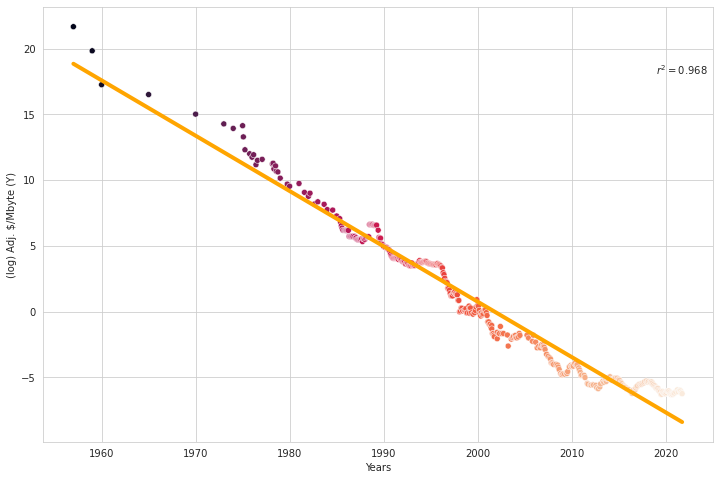

In [13]:
# Recover cost of memory for older dates
mem_x = np.array(memory_prices_df[['date (X)', 'Adj. $/Mbyte (Y)']]['date (X)'])
mem_y = np.log(memory_prices_df[['date (X)', 'Adj. $/Mbyte (Y)']]['Adj. $/Mbyte (Y)']).tolist()

mem_x_2 = mem_x.reshape((-1, 1))
reg = LinearRegression().fit(mem_x_2, mem_y)
preds = reg.predict(mem_x_2)
r2 = r2_score(mem_y, preds)
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
sns.lineplot(mem_x, preds, color='orange', lw=4)
sns.scatterplot(mem_x, mem_y, hue=mem_x, palette="rocket", legend=False)
plt.text(2019, 18, r"$r^{2} = 0.968$")
plt.xlabel('Years')
plt.ylabel('(log) Adj. $/Mbyte (Y)')
plt.savefig('figures/mem_cost.png')
plt.show()

In [14]:
unobserved_labels = np.array([1944.00 + i for i in range(13)]).reshape((-1, 1))
recovered_estimates = np.exp(reg.predict(unobserved_labels))
recovered_estimates

array([3.67493558e+10, 2.41252517e+10, 1.58377680e+10, 1.03971928e+10,
       6.82555895e+09, 4.48084937e+09, 2.94159221e+09, 1.93109923e+09,
       1.26772984e+09, 8.32240480e+08, 5.46350014e+08, 3.58668372e+08,
       2.35458951e+08])

In [15]:
for i in range(len(unobserved_labels)):
    memory_prices_df = memory_prices_df.append({'date (X)': unobserved_labels[i][0], '$/Mbyte (Y)': recovered_estimates[i], 'Adj. $/Mbyte (Y)': cpi.inflate(recovered_estimates[i], int(unobserved_labels[i][0]), to=2001)}, ignore_index=True)

In [16]:
memory_prices_df = memory_prices_df.sort_values(by=['date (X)']).reset_index(drop=True)
memory_prices_df["Adj. $/Mbyte (Y)"] = memory_prices_df.apply(lambda x: cpi.inflate(x["$/Mbyte (Y)"], 2001), axis=1)

In [17]:
memory_prices_df_filtered = memory_prices_df[memory_prices_df['date (X)'] < 2004]
memory_prices_df_filtered = memory_prices_df_filtered.iloc[:, [0, 1, 14]]
memory_prices_df_filtered.to_csv('datasets/memory_prices.csv')
memory_prices_df_filtered

,date (X),$/Mbyte (Y),Adj. $/Mbyte (Y)
0,1944.00,3.674936e+10,5.622797e+10
1,1945.00,2.412525e+10,3.691259e+10
2,1946.00,1.583777e+10,2.423241e+10
3,1947.00,1.039719e+10,1.590812e+10
4,1948.00,6.825559e+09,1.044337e+10
...,...,...,...
248,2003.58,1.290000e-01,1.973751e-01
249,2003.67,1.430000e-01,2.187957e-01
250,2003.75,1.480000e-01,2.264458e-01
251,2003.83,1.600000e-01,2.448063e-01


In [18]:
# load fabrication dataset
fabrication_df = pd.read_csv('datasets/fabrication.csv')

In [19]:
fabrication_df

,method,invention
0,photolithography,1958
1,e-beam lithography,1980
2,focused ion beam,1995
3,liquid metal ion source,1970
4,scanning probe lithography,1981
5,dip pen lithography,1999


In [20]:
def find_memory(date):
    return memory_prices_df.iloc[(memory_prices_df_filtered['date (X)']-date).abs().argsort()[:]][(memory_prices_df_filtered['date (X)'] <= date)]['$/Mbyte (Y)'].iloc[0]

def find_fabrications(date):
    dates = fabrication_df[' invention'].tolist()
    return [1 if date > d else 0 for d in dates]

In [21]:
Q = cpu_performance_df_filtered['Quantity'].str.replace('est-', '').astype(float, errors='raise').tolist()

In [22]:
P = cpu_performance_df_filtered['Price US$'].tolist()

In [23]:
O = cpu_performance_df_filtered['Performance'].str.replace(',', '').astype(float, errors='raise').tolist() # measured in MIPS

In [24]:
M = np.array([find_memory(year) for year in cpu_performance_df_filtered['Year'].astype(float, errors='raise').tolist()])

In [25]:
F = np.array([find_fabrications(year) for year in cpu_performance_df_filtered['Year'].astype(float, errors='raise').tolist()]).T
F1, F2, F3, F4, F5, F6 = F

In [26]:
F1.shape

(334,)

In [27]:
X = np.zeros((334, 9))
X[:, 0] = Q
X[:, 1] = M
X[:, 2] = O
X[:, 3] = F1
X[:, 4] = F2
X[:, 5] = F3
X[:, 6] = F4
X[:, 7] = F5
X[:, 8] = F6

In [28]:
feature_names = ['Q', 'M', 'O', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6']

In [29]:
Y = P

In [30]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_names = poly_features.get_feature_names(feature_names)

In [31]:
regr = LinearRegression()
regr.fit(X_poly, Y)
pred = regr.predict(X_poly)
coef_map = {}
for idx, coef in enumerate(regr.coef_):
    coef_map[f"beta{idx}"] = (poly_names[idx], coef)
coef_map # list estimated coefficients and variable names

{'beta0': ('1', -0.010407237848709356),
 'beta1': ('Q', 0.014574827039271538),
 'beta2': ('M', 0.039909690940163806),
 'beta3': ('O', 0.07258343461879407),
 'beta4': ('F1', -7.776236868872743e-07),
 'beta5': ('F2', 4.503757232821037e-06),
 'beta6': ('F3', 2.6375719237581308e-06),
 'beta7': ('F4', 3.2100361639919583e-06),
 'beta8': ('F5', 4.474463492609715e-06),
 'beta9': ('F6', -7.985142298494452e-07),
 'beta10': ('Q^2', 0.0006440299731298449),
 'beta11': ('Q M', -0.040021509152785864),
 'beta12': ('Q O', 1.1849656374784658),
 'beta13': ('Q F1', 4.047147670330144e-05),
 'beta14': ('Q F2', 5.3253299065719305e-05),
 'beta15': ('Q F3', 4.1408560314784825e-05),
 'beta16': ('Q F4', 4.373834905502228e-05),
 'beta17': ('Q F5', 5.300162688431768e-05),
 'beta18': ('Q F6', -1.3826703311843334e-05),
 'beta19': ('M^2', 2.55351295663786e-15),
 'beta20': ('M O', 0.11246864496534935),
 'beta21': ('M F1', -0.010918379801175512),
 'beta22': ('M F2', 0.0023740878139579535),
 'beta23': ('M F3', 9.0619554

In [32]:
# Compute partial derivate for practicality score
zeta_betas = ["beta3", "beta12", "beta20", "beta27", "beta28", "beta29", "beta30", "beta31", "beta32", "beta33"]
zeta_coefs = [coef_map[beta][1] for beta in zeta_betas]
rho_betas = ["beta1", "beta10", "beta11", "beta12", "beta13", "beta14", "beta15", "beta16", "beta17", "beta18"]
rho_coefs = [coef_map[beta][1] for beta in rho_betas]

In [33]:
O_fac = np.zeros(334) + zeta_coefs[0]
Q_fac = X[:, 0] * zeta_coefs[1]
M_fac = X[:, 1] * zeta_coefs[2]
O2_fac = X[:, 2] * zeta_coefs[3]
F1_fac = X[:, 3] * zeta_coefs[4]
F2_fac = X[:, 4] * zeta_coefs[5]
F3_fac = X[:, 5] * zeta_coefs[6]
F4_fac = X[:, 6] * zeta_coefs[7]
F5_fac = X[:, 7] * zeta_coefs[8]
F6_fac = X[:, 8] * zeta_coefs[9]
zetas = O_fac + Q_fac + M_fac + O2_fac + F1_fac + F2_fac + F3_fac + F4_fac + F5_fac + F6_fac

In [34]:
Q_fac = np.zeros(334) + rho_coefs[0]
Q2_fac = X[:, 0] * rho_coefs[1]
M_fac = X[:, 1] * rho_coefs[2]
O_fac = X[:, 2] * rho_coefs[3]
F1_fac = X[:, 3] * rho_coefs[4]
F2_fac = X[:, 4] * rho_coefs[5]
F3_fac = X[:, 5] * rho_coefs[6]
F4_fac = X[:, 6] * rho_coefs[7]
F5_fac = X[:, 7] * rho_coefs[8]
F6_fac = X[:, 8] * rho_coefs[9]
rhos = Q_fac + Q2_fac + M_fac + O_fac + F1_fac + F2_fac + F3_fac + F4_fac + F5_fac + F6_fac

In [35]:
years = cpu_performance_df_filtered['Year'].astype(float)

In [36]:
years = np.array(years).reshape((334, -1))
log_zetas = np.nan_to_num(np.log(zetas))
reg = LinearRegression()
reg.fit(np.log(years), log_zetas)
preds = reg.predict(np.log(years))
r2_score(log_zetas, preds), reg.coef_[0]

(0.9498449694718789, -739.9865572957591)

In [37]:
pred_exp = np.exp(log_zetas)

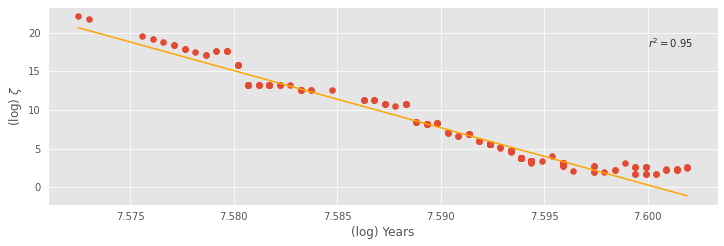

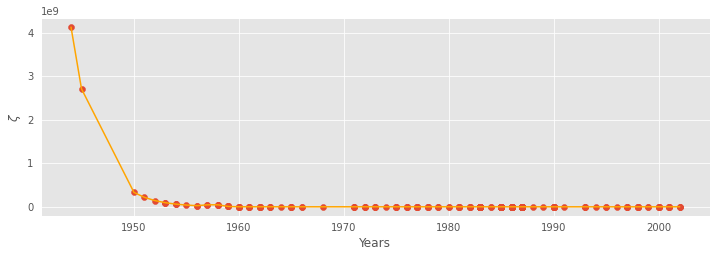

In [38]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(np.log(years), preds, color='orange')
plt.text(7.6, 18, r"$r^{2} = 0.95$")
plt.scatter(np.log(years), np.log(zetas))
plt.ylabel(r"(log) $\zeta$")
plt.xlabel("(log) Years")
plt.show()
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.plot(years, pred_exp, color='orange')
plt.scatter(years, zetas)
plt.ylabel(r"$\zeta$")
plt.xlabel("Years")
plt.show()

In [39]:
log_rhos = np.nan_to_num(np.log(-rhos))
reg = LinearRegression()
reg.fit(np.log(years), log_rhos)
preds = reg.predict(np.log(years))
r2_score(log_rhos, preds), reg.coef_[0]

(0.9287541449415464, -800.3298242428821)

In [40]:
pred_exp = np.exp(log_rhos)

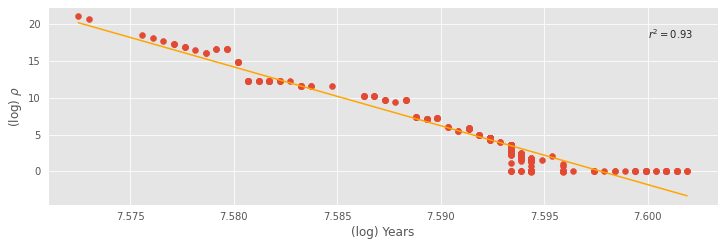

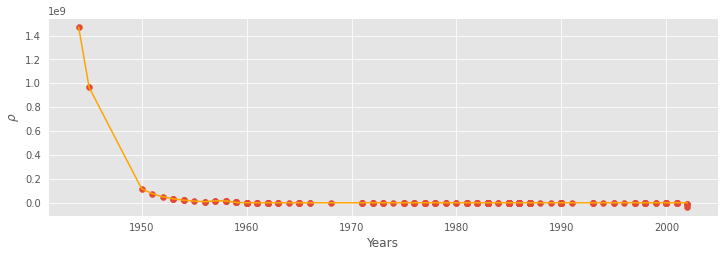

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.text(7.6, 18, r"$r^{2} = 0.93$")
plt.plot(np.log(years), preds, color='orange')
plt.scatter(np.log(years), log_rhos)
plt.ylabel(r"(log) $\rho$")
plt.xlabel("(log) Years")
plt.show()
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.plot(years, pred_exp, color='orange')
plt.scatter(years, -rhos)
plt.ylabel(r"$\rho$")
plt.xlabel("Years")
plt.show()

In [42]:
# Compute elasticities
zeta_elas = zetas * (X[:, 2] / Y)
rho_elas = -rhos * (X[:, 0] / Y)

def elas_avg(time):
    i = 0
    zeta_dec, rho_dec, time_dec = [], [], []
    while i < len(zeta_elas):
        if i+time > len(zetas):
            zeta_dec.append(np.sum(zeta_elas[i:i+time]) / (len(zeta_elas) % time))
            rho_dec.append(np.sum(rho_elas[i:i+time]) / (len(rho_elas) % time))
            time_dec.append(np.sum(years[i:i+time]) / (len(years) % time))
        else:
            zeta_dec.append(np.sum(zeta_elas[i:i+time]) / time)
            rho_dec.append(np.sum(rho_elas[i:i+time]) / time)
            time_dec.append(np.sum(years[i:i+time]) / time)
        i += time
    return zeta_dec, rho_dec, time_dec
zeta_ma5, rho_ma5, ma5 = elas_avg(5)
zeta_ma10, rho_ma10, ma10 = elas_avg(10)
zeta_ma20, rho_ma20, ma20 = elas_avg(20)
zeta_ma40, rho_ma40, ma40 = elas_avg(40)

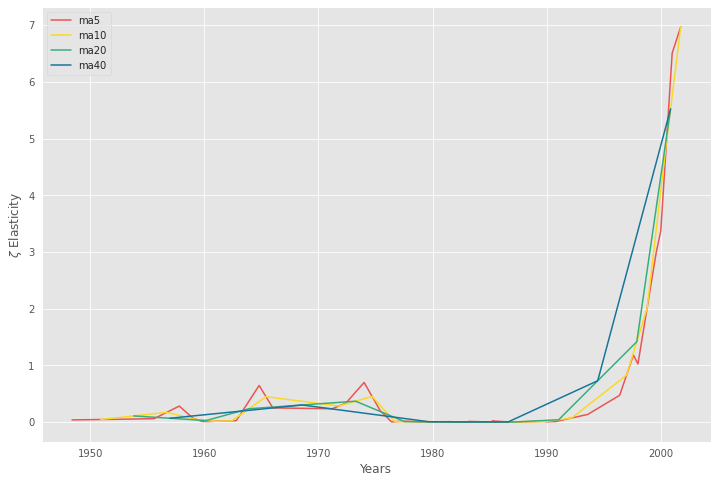

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
line1 = ax.plot(ma5, zeta_ma5, color='#EB5353', label='ma5')
line2 = ax.plot(ma10, zeta_ma10, color='#F9D923', label='ma10')
line3 = ax.plot(ma20, zeta_ma20, color='#36AE7C', label='ma20')
line4 = ax.plot(ma40, zeta_ma40, color='#187498', label='ma40')
plt.legend(['ma5', 'ma10', 'ma20', 'ma40'])
plt.xlabel('Years')
plt.ylabel(r'$\zeta$ Elasticity')
plt.savefig('figures/zeta_el_ma.png')
plt.show()

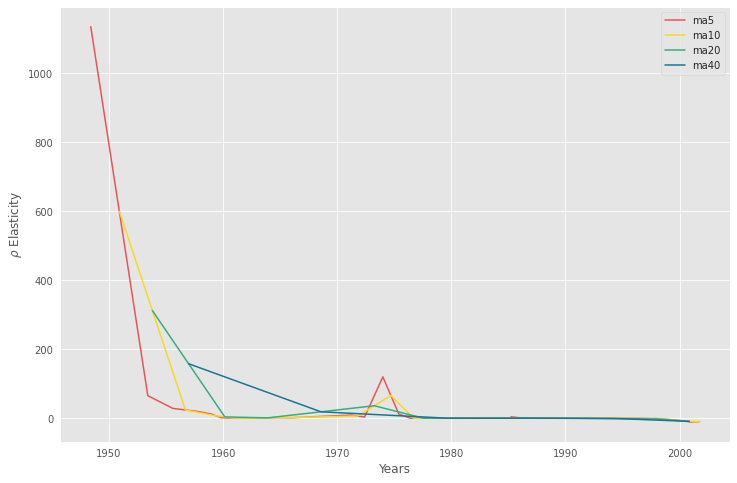

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
line1 = ax.plot(ma5, rho_ma5, color='#EB5353', label='ma5')
line2 = ax.plot(ma10, rho_ma10, color='#F9D923', label='ma10')
line3 = ax.plot(ma20, rho_ma20, color='#36AE7C', label='ma20')
line4 = ax.plot(ma40, rho_ma40, color='#187498', label='ma40')
plt.legend(['ma5', 'ma10', 'ma20', 'ma40'])
plt.xlabel('Years')
plt.ylabel(r'$\rho$ Elasticity')
plt.savefig('figures/rho_el_ma.png')
plt.show()

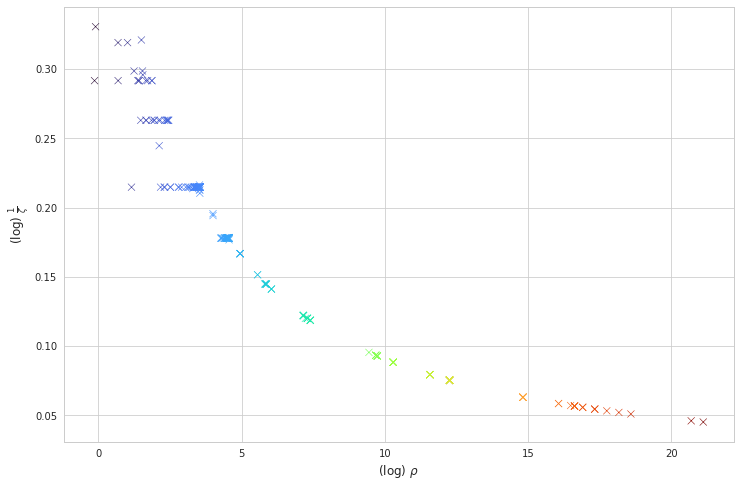

In [45]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
sns.scatterplot(np.log(-rhos), 1/np.log(zetas), hue=np.log(-rhos), marker='x', palette="turbo", legend=False, s=50)
plt.ylabel(r"(log) $\frac{1}{\zeta}$")
plt.xlabel(r"(log) $\rho$")
plt.savefig('figures/indiff_curve.png')
plt.show()

In [46]:
quantum_scores = pd.read_csv("./datasets/quantum_scores.csv")
quantum_inv_zeta = quantum_scores['inv_zeta'].tolist()
quantum_rho = quantum_scores['rho'].tolist()

In [47]:
molecular_scores = pd.read_csv("./datasets/molecular_scores.csv")
molecular_inv_zeta = molecular_scores['inv_zeta'].tolist()
molecular_rho = molecular_scores['rho'].tolist()

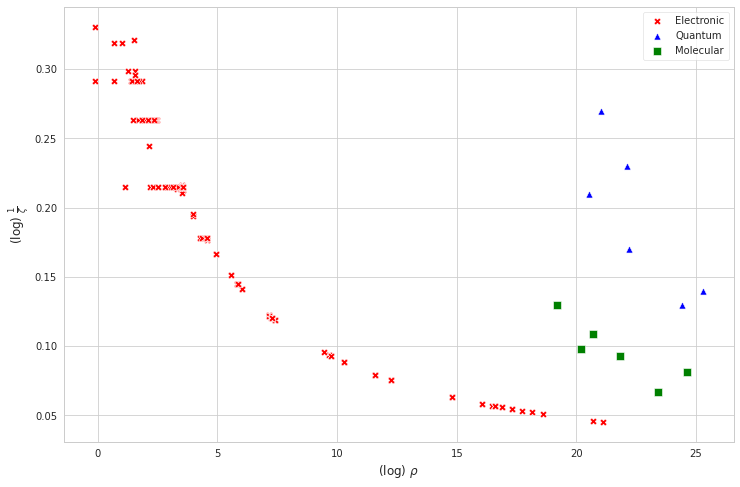

In [48]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
sns.scatterplot(np.log(-rhos), 1/np.log(zetas), marker='X', color="red", s=50)
sns.scatterplot(quantum_rho, quantum_inv_zeta, marker="^", color="blue", s=50)
sns.scatterplot(molecular_rho, molecular_inv_zeta, marker="s", color="green", s=50)
plt.ylabel(r"(log) $\frac{1}{\zeta}$")
plt.xlabel(r"(log) $\rho$")
plt.legend(['Electronic', 'Quantum', 'Molecular'])
plt.savefig('figures/indiff_curve_all.png')
plt.show()

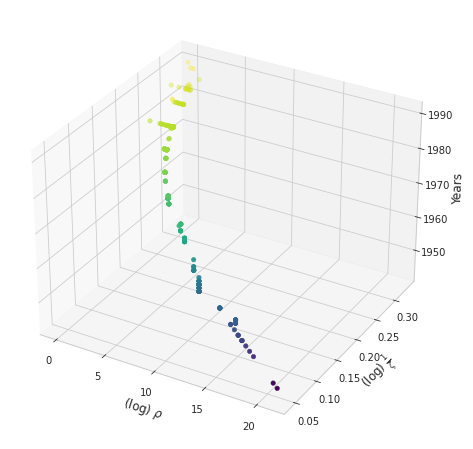

In [50]:
plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel(r"(log) $\rho$")
ax.set_ylabel(r"(log) $\frac{1}{\zeta}$")
ax.set_zlabel("Years")
ax.scatter3D(np.log(-rhos), 1/np.log(zetas), years.T[0], c=years.T[0], cmap='viridis', linewidth=0.5)
plt.show()